### GEDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats
from datetime import datetime

In [7]:
df = pd.read_csv('../Volumes/MemoriaEle/HeavyData/incidentes-viales-c5.csv')

### Preparando base

In [8]:
df.shape

(1383138, 18)

#### Código cierre

In [9]:
df = df.replace({'(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada':'A_afirmativo',
                          '(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad': 'N_negativo',
                          '(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente':'D_diferido',
                         '(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente':'F_falsa',
                          '(I) El incidente reportado es afirmativo y se añade información adicional al evento': 'I_informativo'}) 

#### Detectando nulos

In [10]:
df.isnull().sum()

folio                  0
fecha_creacion         0
hora_creacion          0
dia_semana             0
codigo_cierre          0
fecha_cierre           0
año_cierre             0
mes_cierre             0
hora_cierre            0
delegacion_inicio    158
incidente_c4           0
latitud              443
longitud             435
clas_con_f_alarma      0
tipo_entrada           0
delegacion_cierre    140
geopoint             446
mes                    0
dtype: int64

Debido a que son muy pocos se decidió quitarlos de la base.

In [11]:
df = df.dropna()

#### Quitando coordenadas fuera de la CDMX

In [12]:
df = df[df['longitud'] > -99.35]

In [13]:
df = df[df['latitud'] < 20]

In [14]:
df.shape

(1382502, 18)

In [15]:
# Separa fecha_inicio en tres diferentes columnas: dia, mes, anio
# Y las agrega a la base df
fechas_inicio = df.fecha_creacion.str.split("/", n=2,expand=True)
df['dia_inicio']=fechas_inicio[0]
df['mes_inicio']=fechas_inicio[1]
df['anio_inicio']=fechas_inicio[2]

In [16]:
# Sabemos que hay valores de 19 y en la base por lo que los reemplazamos
df['anio_inicio'] = df['anio_inicio'].replace(['19'],'2019')
df['anio_inicio'] = df['anio_inicio'].replace(['18'],'2018')

In [17]:
df.shape

(1382502, 21)

- Sabemos que las columnas que tienen el identificador de cierre no nos podrían dar un indicio para clasificar adecuadamente las falsas alarmas pues son datos que están aposteriori al evento de interés, por lo tanto las quitaremos de la base. Adicionalmente se quitará la variable de geopoint pues es la misma información de latitud y longitud. 

In [18]:
df = df.drop(['fecha_cierre',
         'año_cierre',
         'mes_cierre',
         'hora_cierre',
         'delegacion_cierre',
         'mes',
        'geopoint'],axis='columns')

Pasamos a formato fecha la variable de fecha_creacion

In [19]:
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'])

Pasamos a formato tiempo la variable de hora_creacion y creamos dos variables más de hora_inicio y min_inicio. 

In [20]:
df['hora_creacion']=pd.to_timedelta(df['hora_creacion'],errors='ignore')
hora_inicio = df.hora_creacion.str.split(":", n=2,expand=True)
df['hora_inicio']=hora_inicio[0]
df['min_inicio']=hora_inicio[1]
df['hora_inicio']=round(df['hora_inicio'].apply(lambda x: float(x)),0)

Haciendo otra variable que clasifique como verdadero o falso

In [21]:
df["falsa_class"] = df["codigo_cierre"].apply(lambda x: "Falsa" if
                                                (x == "N_negativo") |
                                                (x == "F_falsa") 
                                                else "Verdadera")

Además creamos dos bases para apoyo en los gráficos

In [22]:
cierto = df.loc[df['codigo_cierre'].isin(['A_afirmativo','D_diferido','I_informativo'])]
falso = df.loc[df['codigo_cierre'].isin(['F_falsa','N_negativo'])]

In [23]:
df.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,dia_inicio,mes_inicio,anio_inicio,hora_inicio,min_inicio,falsa_class
0,GA/160123/05714,2016-01-23,22:35:04,Sábado,A_afirmativo,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,23,01,2016,22.0,35,Verdadera
1,AO/160123/05826,2016-01-23,22:50:49,Sábado,A_afirmativo,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,23,01,2016,22.0,50,Verdadera
2,C4/160124/02187,2016-01-24,09:40:11,Domingo,N_negativo,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,24,01,2016,9.0,40,Falsa
3,C4/160124/05723,2016-01-24,22:40:57,Domingo,N_negativo,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,24,01,2016,22.0,40,Falsa
4,C4/160124/01334,2016-01-24,04:25:15,Domingo,A_afirmativo,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,24,01,2016,4.0,25,Verdadera


# Gráficos

### 1. De manera global, cual es el comportamiento de los incidentes a través de los años.

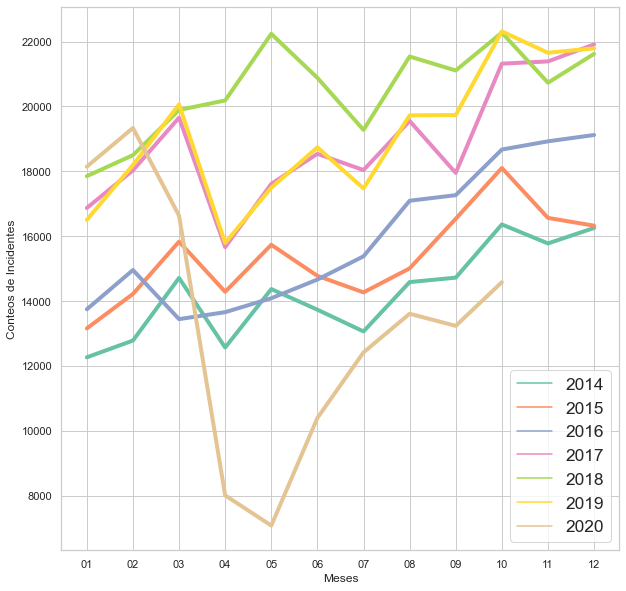

In [24]:
# Columns de anio_inicio, mes_inicio y counts
fecha_separated = df.groupby(['anio_inicio','mes_inicio']).size().reset_index(name="conteos")
# Eliminamos primer renglón
fecha_separated=fecha_separated.drop(0)
# Hacemos tabla donde las columnas son años y las filas mes inicio
fecha_separated_p = fecha_separated.pivot("mes_inicio", "anio_inicio","conteos")
# Graficamos 
sns.set(style='whitegrid',rc={'figure.figsize':(10,10)},palette='Set2')
h =sns.lineplot(data=fecha_separated_p,linewidth = 4,dashes=False)
plt.legend(fontsize='x-large', title_fontsize='40',loc='lower right')
h.set(xlabel='Meses',ylabel='Conteos de Incidentes')
plt.show()

### 2. ¿Es importante la temporalidad año, día, mes para el modelo? 

In [25]:
# Con variable fecha_creacion ya en formato tiempo creamos conteos
# del número de registros hechos por día
conteos_fechas = cierto.groupby(['fecha_creacion']).size().reset_index(name='conteos')
conteos_fechas = conteos_fechas.drop(0)
# hacemos que fecha_creacion sea el identificador de las filas
conteos_fechas = conteos_fechas.set_index('fecha_creacion')

In [26]:
# Separamos los días, meses, años
conteos_fechas.insert(1, 'year', conteos_fechas.index.year)
conteos_fechas.insert(2, 'month', conteos_fechas.index.month)
conteos_fechas.insert(3, 'day', conteos_fechas.index.day)
conteos_fechas = conteos_fechas.copy()

In [27]:
# Definimos una función para hacer más fácil los heatmaps
def heatmaps(data,choose_year,axis,yes,ylabel):
    data1 = data.loc[data['year'] == choose_year]
    data1 = data1.pivot_table(index="day",columns="month",values='conteos')
    if yes == 'yes':
        heat = sns.heatmap(data1, cbar=True, ax=axis,cmap="RdBu")
    else:
        heat = sns.heatmap(data1, cbar=False, ax=axis,cmap="RdBu")
    heat.set_title(str(choose_year),fontsize=15)
    heat.set_xlabel('Meses',fontsize=15)
    heat.set_ylabel(ylabel,fontsize=15)
    heat.set_yticklabels(heat.get_yticklabels(), rotation = 0)
    heat.set_xticklabels(heat.get_xticklabels())#, rotation = 90, fontsize = 8)
    return heat

<AxesSubplot:title={'center':'2020'}, xlabel='Meses'>

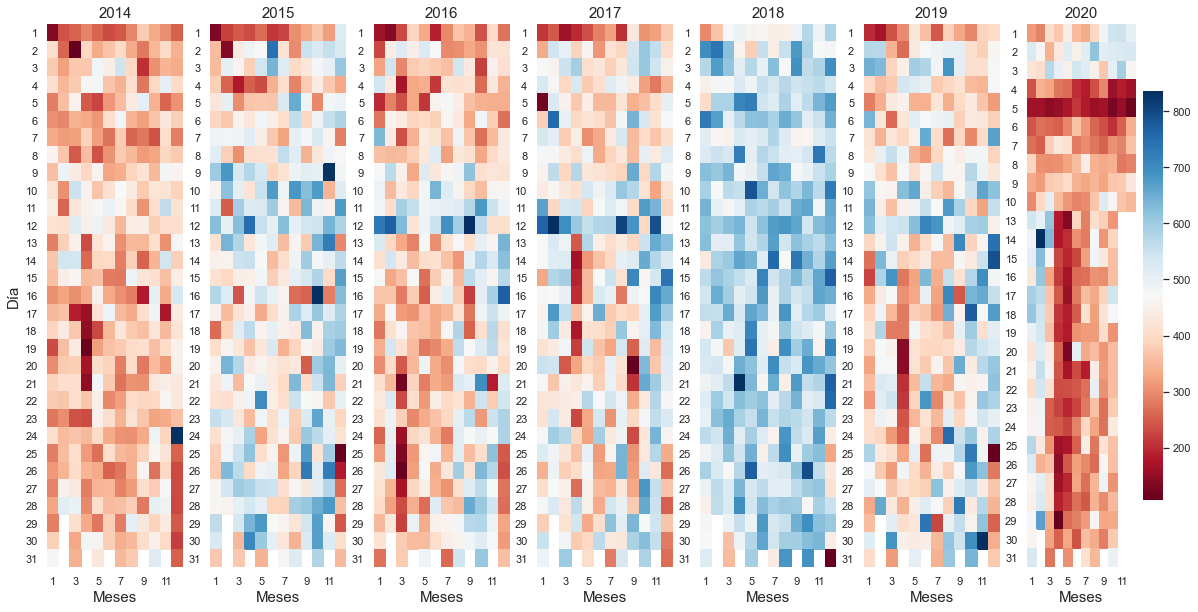

In [28]:
# Graficamos
fig, axs = plt.subplots(figsize=(20,10),ncols=7)
heatmaps(conteos_fechas,2014,axs[0],'no','Día')
heatmaps(conteos_fechas,2015,axs[1],'no','')
heatmaps(conteos_fechas,2016,axs[2],'no','')
heatmaps(conteos_fechas,2017,axs[3],'no','')
heatmaps(conteos_fechas,2018,axs[4],'no','')
heatmaps(conteos_fechas,2019,axs[5],'no','')
heatmaps(conteos_fechas,2020,axs[6],'yes','')

Ahora lo comparamos contra la categoría que queremos clasificar

In [29]:
# Falso
conteos_fechas = falso.groupby(['fecha_creacion']).size().reset_index(name='conteos')
conteos_fechas = conteos_fechas.drop(0)
conteos_fechas = conteos_fechas.set_index('fecha_creacion')
conteos_fechas.insert(1, 'year', conteos_fechas.index.year)
conteos_fechas.insert(2, 'month', conteos_fechas.index.month)
conteos_fechas.insert(3, 'day', conteos_fechas.index.day)
conteos_fechas = conteos_fechas.copy()

<AxesSubplot:title={'center':'2020'}, xlabel='Meses'>

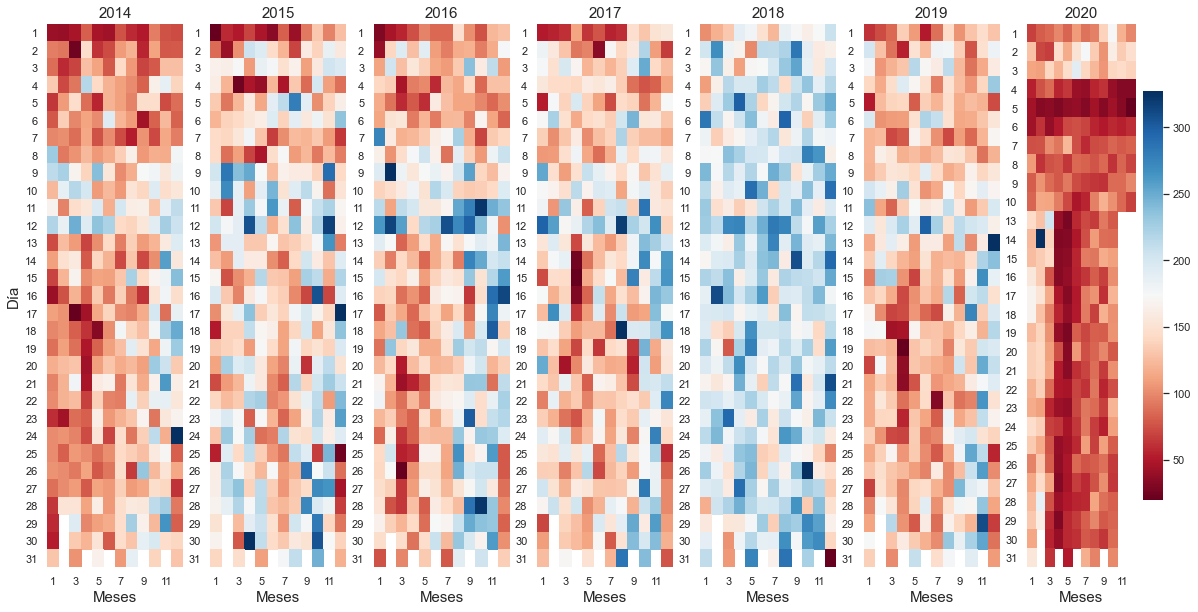

In [30]:
fig, axs = plt.subplots(figsize=(20,10),ncols=7)
heatmaps(conteos_fechas,2014,axs[0],'no','Día')
heatmaps(conteos_fechas,2015,axs[1],'no','')
heatmaps(conteos_fechas,2016,axs[2],'no','')
heatmaps(conteos_fechas,2017,axs[3],'no','')
heatmaps(conteos_fechas,2018,axs[4],'no','')
heatmaps(conteos_fechas,2019,axs[5],'no','')
heatmaps(conteos_fechas,2020,axs[6],'yes','')

### 3. Mapa que indica los lugares donde se han tenido reporte viales diferencia entre verdaderos y falsos

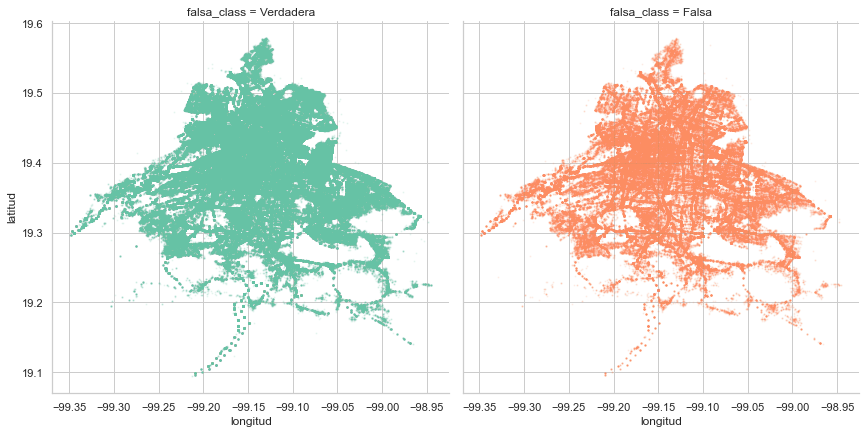

In [31]:
sns.set(style='whitegrid',rc={'figure.figsize':(20,10)},palette='Set2')
s = sns.lmplot(x='longitud',y='latitud',data=df,hue='falsa_class',col='falsa_class',fit_reg=False,height=6,
               scatter_kws={"s":1,"alpha":0.1})

### 4. Relación entre el incidente y el código de cierre

In [32]:
conteos_cod_cierre=df.groupby(["codigo_cierre","incidente_c4"]).size().reset_index(name="counts")
conteos_cod_cierre=conteos_cod_cierre.pivot("incidente_c4","codigo_cierre","counts")
conteos_cod_cierre=conteos_cod_cierre.fillna(0)
conteos_cod_cierre['total']=conteos_cod_cierre.sum(1)
conteos_cod_cierre =conteos_cod_cierre.sort_values('N_negativo',ascending=False)
conteos_cod_cierre

codigo_cierre,A_afirmativo,D_diferido,F_falsa,I_informativo,N_negativo,total
incidente_c4,,,,,,
accidente-choque sin lesionados,341656.0,216404.0,7623.0,3599.0,190956.0,760238.0
accidente-choque con lesionados,127973.0,142522.0,1602.0,751.0,42026.0,314874.0
lesionado-atropellado,82890.0,84895.0,808.0,580.0,24263.0,193436.0
accidente-motociclista,21579.0,26245.0,213.0,25.0,7530.0,55592.0
accidente-volcadura,12102.0,16678.0,94.0,96.0,2770.0,31740.0
accidente-persona atrapada / desbarrancada,3094.0,1306.0,38.0,7.0,1157.0,5602.0
lesionado-accidente automovilístico,3297.0,1854.0,34.0,19.0,849.0,6053.0
accidente-ciclista,1202.0,1029.0,11.0,0.0,476.0,2718.0
accidente-otros,1613.0,386.0,24.0,4.0,437.0,2464.0


In [33]:
proporciones_incidentes=round(conteos_cod_cierre.iloc[:,0:5].apply(lambda x: x/x.sum()*100, axis=1),2)
proporciones_incidentes

codigo_cierre,A_afirmativo,D_diferido,F_falsa,I_informativo,N_negativo
incidente_c4,,,,,
accidente-choque sin lesionados,44.94,28.47,1.00,0.47,25.12
accidente-choque con lesionados,40.64,45.26,0.51,0.24,13.35
lesionado-atropellado,42.85,43.89,0.42,0.30,12.54
accidente-motociclista,38.82,47.21,0.38,0.04,13.55
accidente-volcadura,38.13,52.55,0.30,0.30,8.73
accidente-persona atrapada / desbarrancada,55.23,23.31,0.68,0.12,20.65
lesionado-accidente automovilístico,54.47,30.63,0.56,0.31,14.03
accidente-ciclista,44.22,37.86,0.40,0.00,17.51
accidente-otros,65.46,15.67,0.97,0.16,17.74


In [34]:
conteos_cod_cierre=df.groupby(["falsa_class","incidente_c4"]).size().reset_index(name="counts")
conteos_cod_cierre=conteos_cod_cierre.pivot("incidente_c4","falsa_class","counts")
conteos_cod_cierre=conteos_cod_cierre.fillna(0)
conteos_cod_cierre['total']=conteos_cod_cierre.sum(1)
conteos_cod_cierre =conteos_cod_cierre.sort_values('Verdadera',ascending=False)
conteos_cod_cierre

falsa_class,Falsa,Verdadera,total
incidente_c4,,,
accidente-choque sin lesionados,198579.0,561659.0,760238.0
accidente-choque con lesionados,43628.0,271246.0,314874.0
lesionado-atropellado,25071.0,168365.0,193436.0
accidente-motociclista,7743.0,47849.0,55592.0
accidente-volcadura,2864.0,28876.0,31740.0
lesionado-accidente automovilístico,883.0,5170.0,6053.0
accidente-persona atrapada / desbarrancada,1195.0,4407.0,5602.0
accidente-ciclista,487.0,2231.0,2718.0
accidente-choque con prensados,158.0,2175.0,2333.0


In [35]:
proporciones_incidentes=round(conteos_cod_cierre.iloc[:,0:2].apply(lambda x: x/x.sum()*100, axis=1),2)
proporciones_incidentes=proporciones_incidentes.sort_values('Falsa',ascending=False)
proporciones_incidentes

falsa_class,Falsa,Verdadera
incidente_c4,,
mi ciudad-taxi-incidente de tránsito,100.00,0.00
mi ciudad-calle-incidente de tránsito,50.91,49.09
accidente-vehiculo atrapado,28.04,71.96
accidente-vehículo atrapado-varado,27.23,72.77
accidente-choque sin lesionados,26.12,73.88
detención ciudadana-accidente automovilístico,25.49,74.51
accidente-persona atrapada / desbarrancada,21.33,78.67
accidente-monopatín,19.35,80.65
detención ciudadana-atropellado,18.74,81.26


<AxesSubplot:xlabel='incidente_c4'>

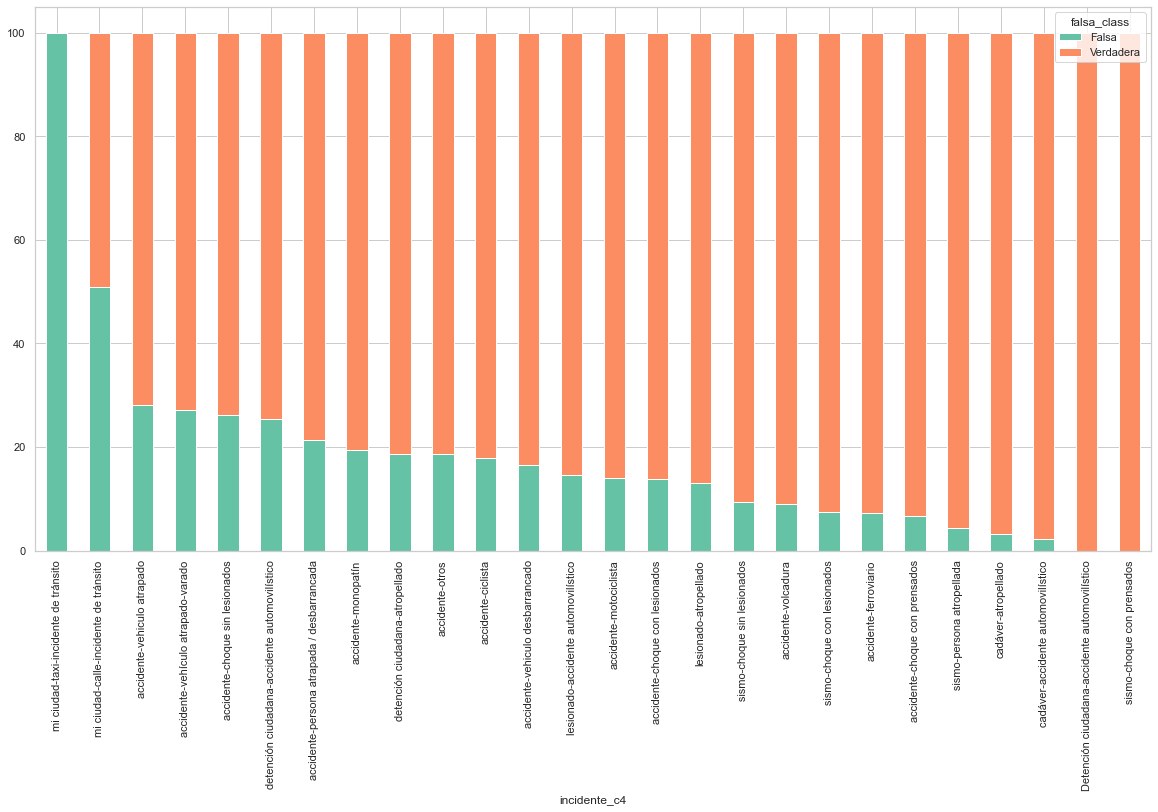

In [36]:
proporciones_incidentes.plot(kind='bar',stacked=True)

### 5. Relación entre tipo de entrada y codigo de cierre, ¿Qué canal es más propenso a que se den falsas alarmas?

In [37]:
bueno=df.groupby(['codigo_cierre','tipo_entrada']).size().reset_index(name="counts")
bueno=bueno.pivot("codigo_cierre", "tipo_entrada","counts")
bueno=bueno.fillna(0)
prop3=round(bueno.iloc[:,:].apply(lambda x: x/x.sum()*100, axis=1),2)
prop3

tipo_entrada,APLICATIVOS,BOTÓN DE AUXILIO,CÁMARA,LLAMADA APP911,LLAMADA DEL 066,LLAMADA DEL 911,RADIO,REDES,ZELLO
codigo_cierre,,,,,,,,,
A_afirmativo,0.00,8.28,0.52,0.40,42.28,35.98,11.87,0.28,0.38
D_diferido,0.01,5.02,0.02,1.04,20.06,72.49,0.58,0.21,0.57
F_falsa,0.00,1.56,0.05,0.66,39.87,54.79,1.96,0.72,0.39
I_informativo,0.00,5.08,0.14,0.14,74.08,14.42,5.49,0.47,0.18
N_negativo,0.01,1.34,0.02,0.67,37.70,57.96,1.15,0.69,0.46


<AxesSubplot:xlabel='codigo_cierre'>

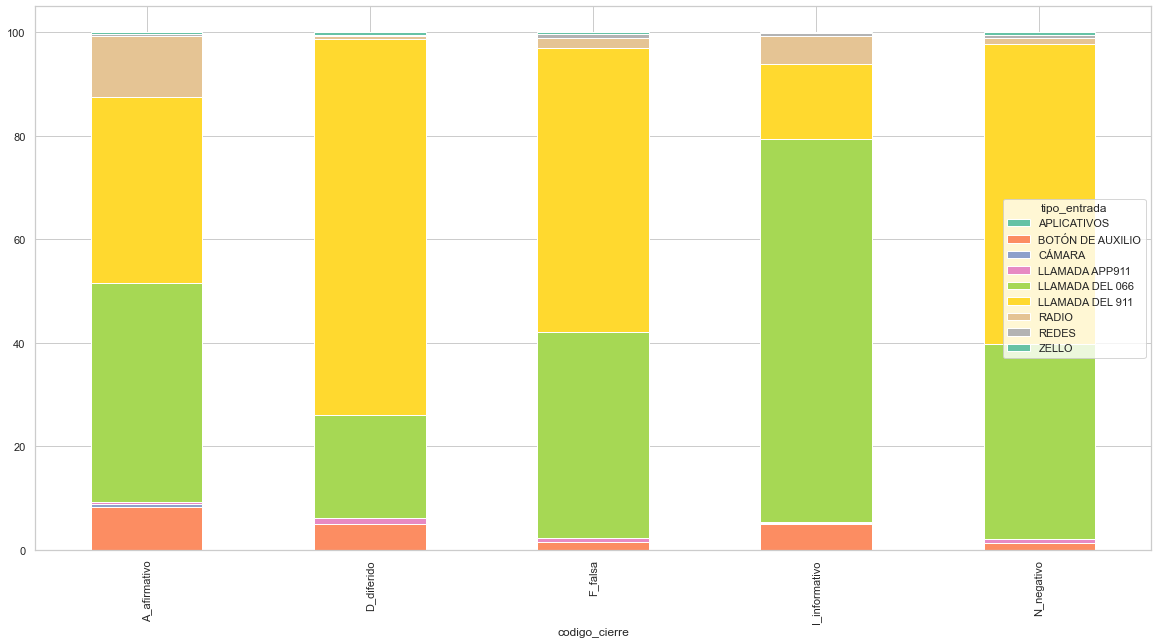

In [38]:
prop3.plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='codigo_cierre'>

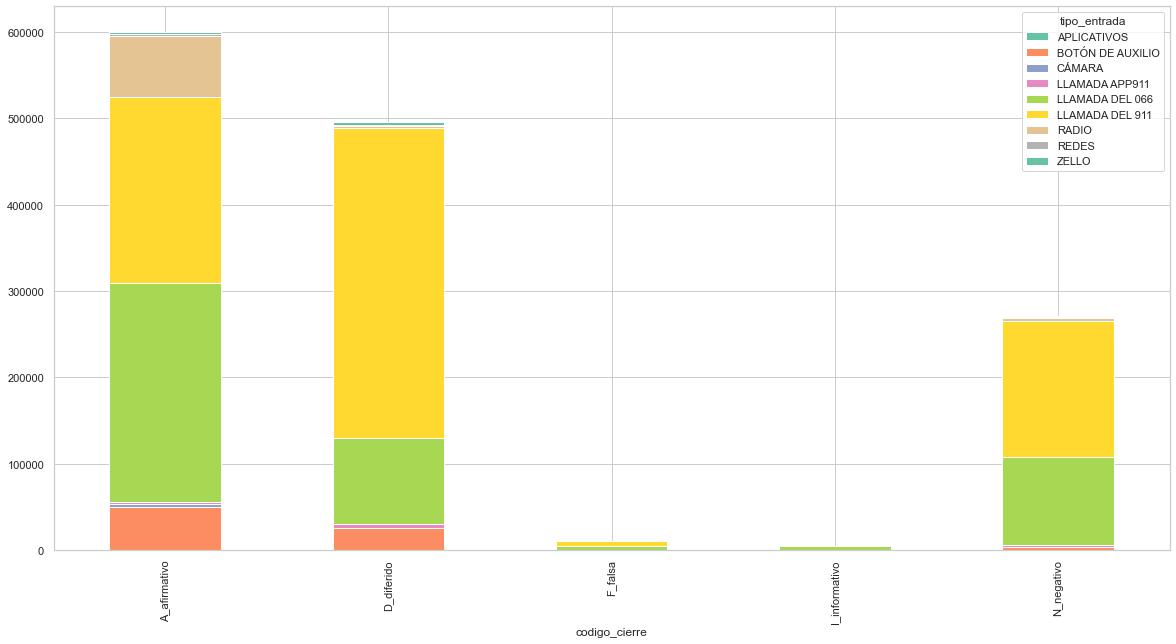

In [39]:
bueno.plot(kind='bar',stacked=True)

### 6. ¿Cómo se ha comportado el uso de canales para reportar emergencias a lo largo del tiempo? ¿Hay algún canal que se esté volviendo particularmente relevante?

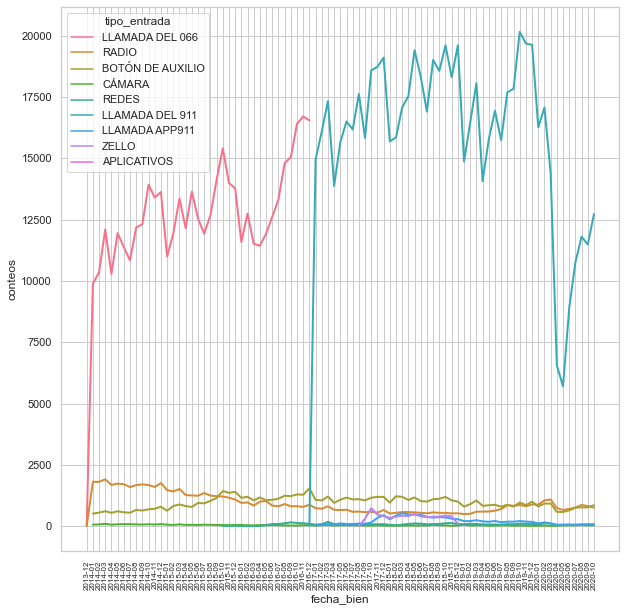

In [40]:
fecha_separated2 = df.groupby(['anio_inicio','mes_inicio','tipo_entrada']).size().reset_index(name="conteos")
fecha_separated2 = fecha_separated2.drop(0)
fecha_separated2['fecha_bien']= fecha_separated2['anio_inicio']+'-'+fecha_separated2['mes_inicio']
hola=fecha_separated2.drop(['anio_inicio','mes_inicio'],1)
hola=hola.set_index('fecha_bien')
sns.set(style='whitegrid',rc={'figure.figsize':(10,10)},palette='Set2')
sns.lineplot(x='fecha_bien',y='conteos',hue='tipo_entrada',data=hola,linewidth = 2)
plt.xticks(rotation= 90,size=8)
plt.show()

In [41]:
df['tipo_entrada'] = df['tipo_entrada'].replace(['LLAMADA DEL 911'],'LLAMADA_911_066')
df['tipo_entrada'] = df['tipo_entrada'].replace(['LLAMADA DEL 066'],'LLAMADA_911_066')

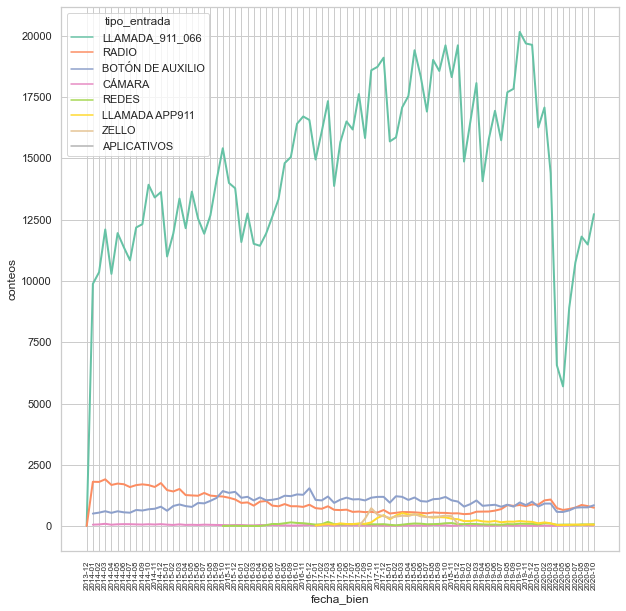

In [42]:
fecha_separated2 = df.groupby(['anio_inicio','mes_inicio','tipo_entrada']).size().reset_index(name="conteos")
fecha_separated2 = fecha_separated2.drop(0)
fecha_separated2['fecha_bien']= fecha_separated2['anio_inicio']+'-'+fecha_separated2['mes_inicio']
hola=fecha_separated2.drop(['anio_inicio','mes_inicio'],1)
hola=hola.set_index('fecha_bien')
sns.set(style='whitegrid',rc={'figure.figsize':(10,10)},palette='Set2')
sns.lineplot(x='fecha_bien',y='conteos',hue='tipo_entrada',data=hola,linewidth = 2)
plt.xticks(rotation= 90,size=8)
plt.show()

### 7. ¿Cómo ha evolucionado la proporción de llamadas falsas (falsas, negativas y ambas) a lo largo del tiempo?

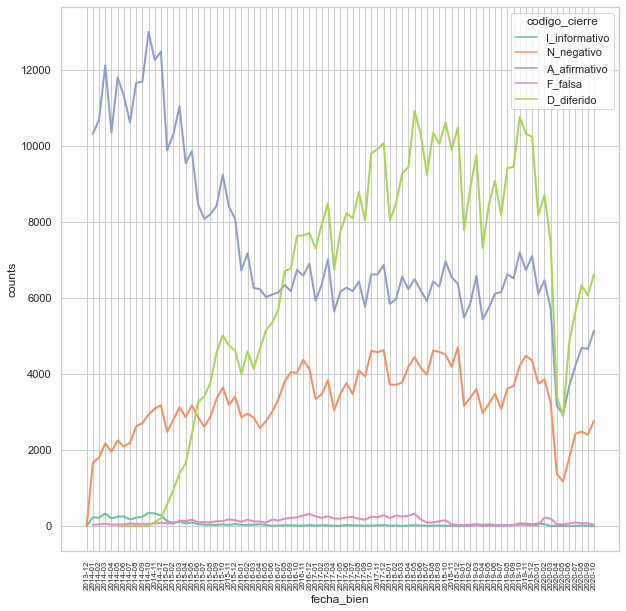

In [43]:
fecha_separated2 = df.groupby(['anio_inicio','mes_inicio','codigo_cierre']).size().reset_index(name="counts")
fecha_separated2 = fecha_separated2.drop(0)
fecha_separated2['fecha_bien']= fecha_separated2['anio_inicio']+'-'+fecha_separated2['mes_inicio']
hola=fecha_separated2.drop(['anio_inicio','mes_inicio'],1)
hola=hola.set_index('fecha_bien')
sns.set(style='whitegrid',rc={'figure.figsize':(10,10)},palette='Set2')
sns.lineplot(x='fecha_bien',y='counts',hue='codigo_cierre',data=hola,linewidth = 2)
plt.xticks(rotation= 90,size=8)
plt.show()

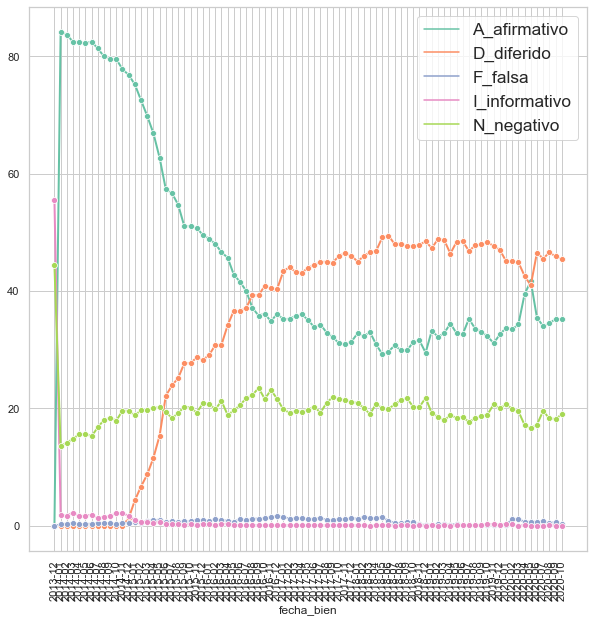

In [44]:
# proporciones
hola2=fecha_separated2.drop(['anio_inicio','mes_inicio'],1)
hola2=hola2.pivot("fecha_bien", "codigo_cierre","counts")
hola2=hola2.fillna(0)
hola2['total']=hola2.sum(1)
prop2=round(hola2.iloc[:,0:5].apply(lambda x: x/x.sum()*100, axis=1),2)
sns.set(style='whitegrid',rc={'figure.figsize':(10,10)},palette='Set2')
h =sns.lineplot(data=prop2,linewidth = 2,dashes=False,marker='o')
plt.xticks(rotation= 90)
plt.legend(fontsize='x-large', title_fontsize='40')
plt.show()

### 8. ¿Cuáles son los días de la semana y las horas del día en las que más se presentan llamadas falsas? 

In [45]:
conteos_tiempo = cierto.groupby(['mes_inicio','hora_inicio','dia_semana']).size().reset_index(name='conteos')

In [46]:
def heat2(data,mes,yes,mes_nombre,axis):
    data1 = data.loc[data['mes_inicio'] == mes]
    data1 = data1.pivot_table(index="hora_inicio",columns="dia_semana",values='conteos')
    data1 = data1[['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']]
    if yes == 'yes':
        heat = sns.heatmap(data1, cbar=True, ax=axis,cmap="RdBu")
    else:
        heat = sns.heatmap(data1, cbar=False, ax=axis,cmap="RdBu")
    heat.set_title(str(mes_nombre),fontsize=15)
    heat.set_xlabel(' ',fontsize=1)
    heat.set_ylabel('',fontsize=15)
    heat.set_yticklabels(heat.get_yticklabels(), rotation = 0)
    heat.set_xticklabels(heat.get_xticklabels())#, rotation = 90, fontsize = 8)
    return heat

<AxesSubplot:title={'center':'Diciembre'}, xlabel=' '>

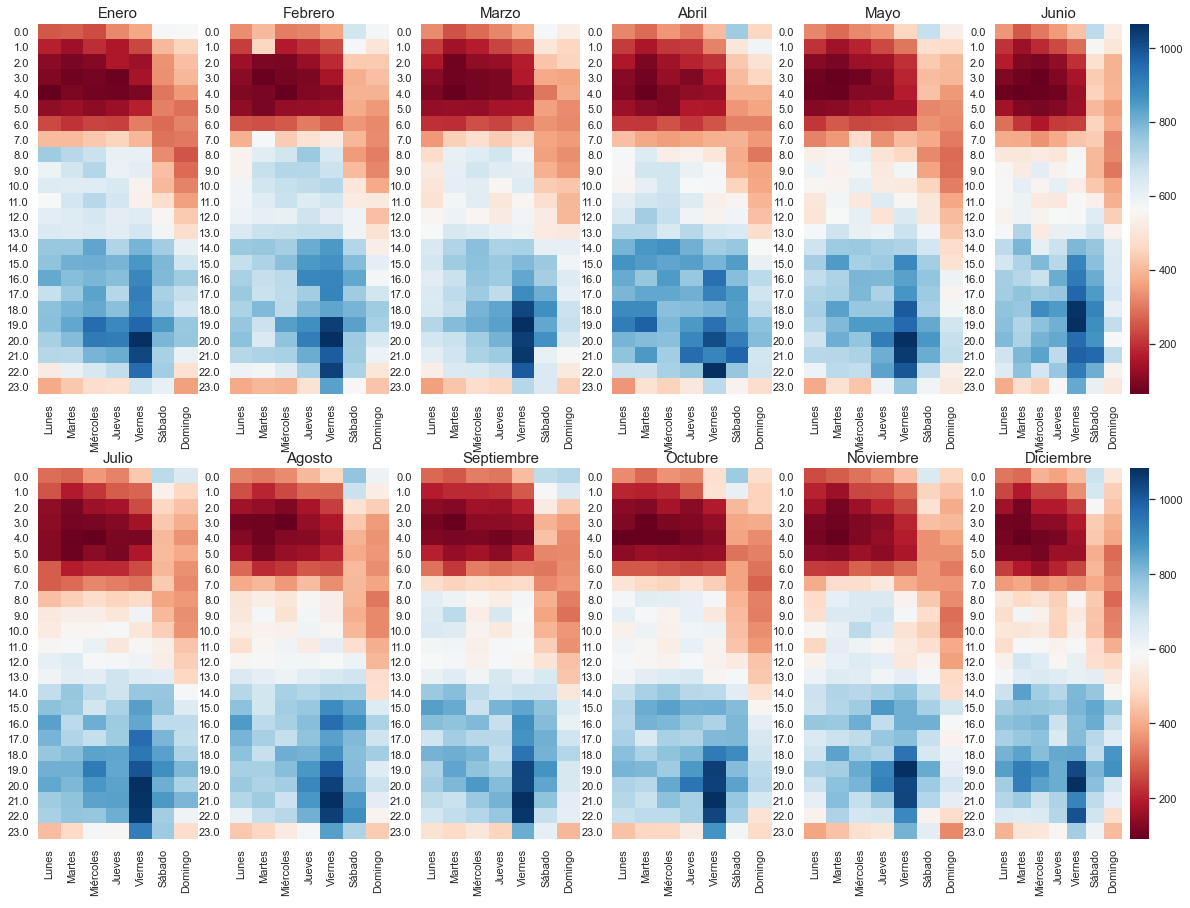

In [47]:
conteos_tiempo = cierto.groupby(['mes_inicio','hora_inicio','dia_semana']).size().reset_index(name='conteos')
fig, axs = plt.subplots(figsize=(20,15),ncols=6,nrows=2)
heat2(conteos_tiempo,'01','no','Enero',axs[0][0])
heat2(conteos_tiempo,'02','no','Febrero',axs[0][1])
heat2(conteos_tiempo,'03','no','Marzo',axs[0][2])
heat2(conteos_tiempo,'04','no','Abril',axs[0][3])
heat2(conteos_tiempo,'05','no','Mayo',axs[0][4])
heat2(conteos_tiempo,'06','yes','Junio',axs[0][5])
heat2(conteos_tiempo,'07','no','Julio',axs[1][0])
heat2(conteos_tiempo,'08','no','Agosto',axs[1][1])
heat2(conteos_tiempo,'09','no','Septiembre',axs[1][2])
heat2(conteos_tiempo,'10','no','Octubre',axs[1][3])
heat2(conteos_tiempo,'11','no','Noviembre',axs[1][4])
heat2(conteos_tiempo,'12','yes','Diciembre',axs[1][5])

<AxesSubplot:title={'center':'Diciembre'}, xlabel=' '>

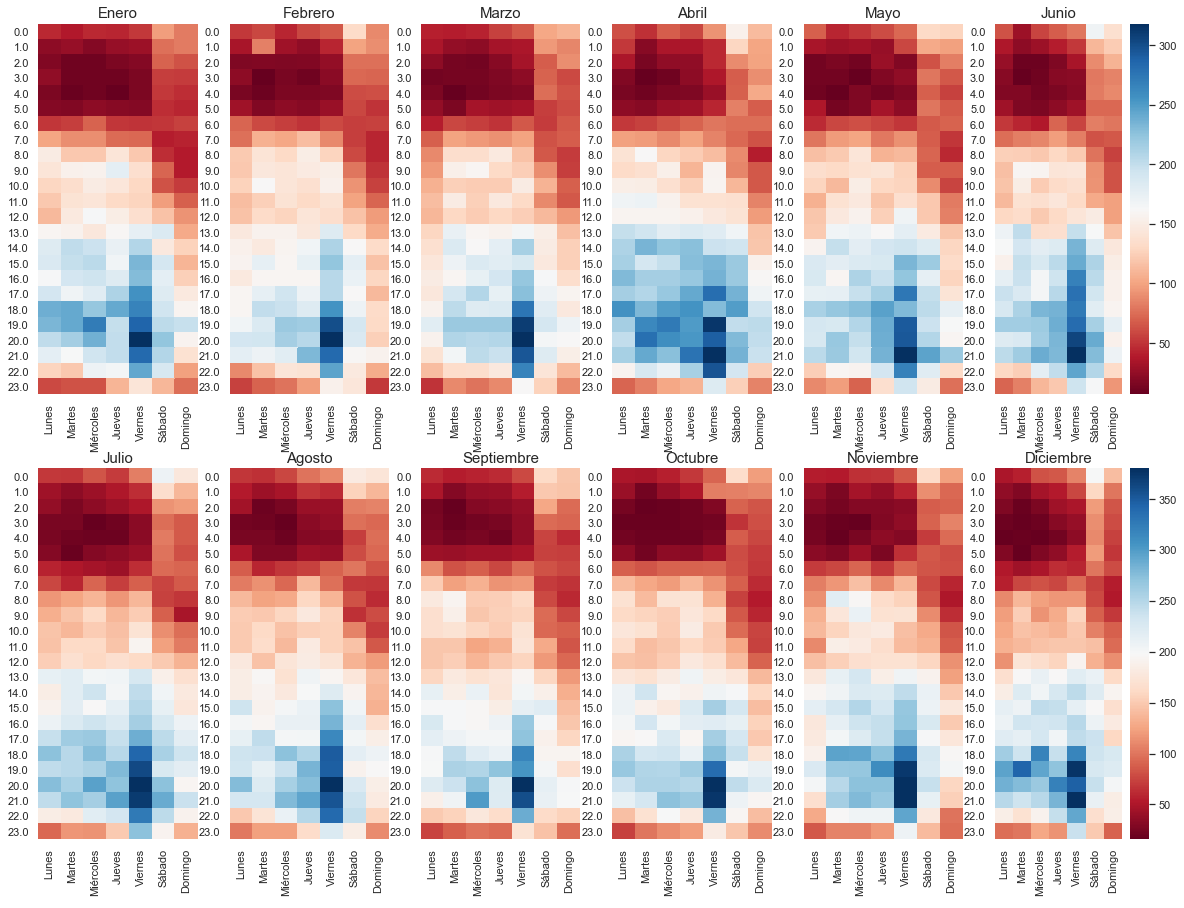

In [48]:
# Falso
conteos_tiempo = falso.groupby(['mes_inicio','hora_inicio','dia_semana']).size().reset_index(name='conteos')
fig, axs = plt.subplots(figsize=(20,15),ncols=6,nrows=2)
heat2(conteos_tiempo,'01','no','Enero',axs[0][0])
heat2(conteos_tiempo,'02','no','Febrero',axs[0][1])
heat2(conteos_tiempo,'03','no','Marzo',axs[0][2])
heat2(conteos_tiempo,'04','no','Abril',axs[0][3])
heat2(conteos_tiempo,'05','no','Mayo',axs[0][4])
heat2(conteos_tiempo,'06','yes','Junio',axs[0][5])
heat2(conteos_tiempo,'07','no','Julio',axs[1][0])
heat2(conteos_tiempo,'08','no','Agosto',axs[1][1])
heat2(conteos_tiempo,'09','no','Septiembre',axs[1][2])
heat2(conteos_tiempo,'10','no','Octubre',axs[1][3])
heat2(conteos_tiempo,'11','no','Noviembre',axs[1][4])
heat2(conteos_tiempo,'12','yes','Diciembre',axs[1][5])

### 9. ¿Qué delagaciones tienen más reportes falsos?

Número de reportes falsos y verdaderos por delegación:

In [93]:
conteos_del=df.groupby(["falsa_class","delegacion_inicio"]).size().reset_index(name="counts")
conteos_del=conteos_del.pivot("delegacion_inicio","falsa_class","counts")
conteos_del=conteos_del.fillna(0)
conteos_del['Total']=conteos_del.sum(1)
conteos_del =conteos_del.sort_values('Falsa',ascending=False)
conteos_del

falsa_class,Falsa,Verdadera,Total
delegacion_inicio,,,
IZTAPALAPA,50317,173285,223602
GUSTAVO A. MADERO,27924,116651,144575
COYOACAN,23732,86387,110119
MIGUEL HIDALGO,22665,93177,115842
ALVARO OBREGON,22428,79621,102049
TLALPAN,21305,66017,87322
CUAUHTEMOC,20834,120488,141322
VENUSTIANO CARRANZA,18052,76297,94349
BENITO JUAREZ,17869,86432,104301


Porcentaje de reportes falsos y verdaderos por delegación:

In [94]:
proporciones_del=round(conteos_del.iloc[:,0:2].apply(lambda x: x/x.sum()*100, axis=1),2)
proporciones_del=proporciones_del.sort_values('Falsa',ascending=False)
proporciones_del

falsa_class,Falsa,Verdadera
delegacion_inicio,,
CUAJIMALPA,31.52,68.48
MAGDALENA CONTRERAS,27.81,72.19
TLALPAN,24.40,75.60
XOCHIMILCO,23.82,76.18
MILPA ALTA,23.64,76.36
TLAHUAC,23.53,76.47
IZTAPALAPA,22.50,77.50
ALVARO OBREGON,21.98,78.02
COYOACAN,21.55,78.45


In [99]:
df_delgraf=conteos_del.merge(proporciones_del, on="delegacion_inicio")
df_delgraf.rename(columns={'Falsa_x':'Número de reportes falsos',
                        'Falsa_y':'Porcentaje de reportes falsos',
                        'Verdadera_x':'Número de reportes verdaderos',
                        'Verdadera_y':'Porcentaje de reportes verdaderos'},inplace=True)

df_delgraf

falsa_class,Número de reportes falsos,Número de reportes verdaderos,Total,Porcentaje de reportes falsos,Porcentaje de reportes verdaderos
delegacion_inicio,,,,,
IZTAPALAPA,50317,173285,223602,22.50,77.50
GUSTAVO A. MADERO,27924,116651,144575,19.31,80.69
COYOACAN,23732,86387,110119,21.55,78.45
MIGUEL HIDALGO,22665,93177,115842,19.57,80.43
ALVARO OBREGON,22428,79621,102049,21.98,78.02
TLALPAN,21305,66017,87322,24.40,75.60
CUAUHTEMOC,20834,120488,141322,14.74,85.26
VENUSTIANO CARRANZA,18052,76297,94349,19.13,80.87
BENITO JUAREZ,17869,86432,104301,17.13,82.87


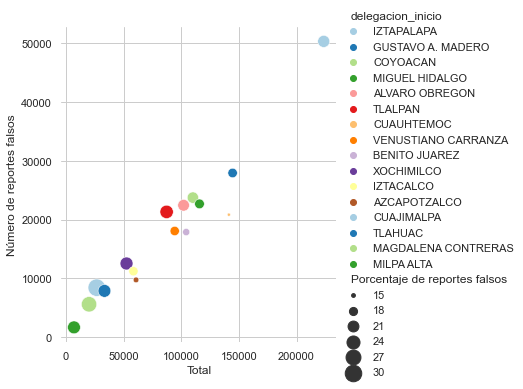

In [122]:
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df_delgraf,
    x="Total", y="Número de reportes falsos",
    hue="delegacion_inicio", size="Porcentaje de reportes falsos",palette="Paired",sizes=(10,300), legend="auto")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)